# Audio Frontend for Xylo-A3 with AGC

In the other notebook (in this folder), we investigated the simulation of modules in the frontend of Xylo-A3, consisting of the PDM microphone.
This corresponds to the first signal path from the analog audio signal until the input of filterbank. We called this module PDM ADC.

In Xylo-A3, we have another signal path which starts from an ordinary microphone and consists of following modules:
- ordinary microphone producing an analog signal
- analog frontend consisting of fixed amplifier + anti-aliasing 1st order low-pass filter.
- AGC (automatic gain controller) module consisting of
  - PGA (programmable gain amplifier) whose gain can be adjusted in the range [1,30] with a 4-bit index control signal, which yields 16 possible gain levels.
  - Equivalent ADC implamented in two steps to eliminate the aliasing noise as much as possible:
    - high-rate ADC: to reduce anti-aliasing noise, the analog signal is sampled with 1, 2, or 4 times target audio sampling rate.
    - anti-aliasing + decimation filter: the resulting high-rate signal is then low-pass filtered and decimated to obtain a 10-bit signal.
  - AGC: output the equ-ADC is forwarded to an AGC module which measures the signal level and if it is low it sends control commands to PGA to increase the amplification gain. Also AGC makes sure that the signal amplification is reduces as soon as signal level goes up to avoid truncating the signal.
  
One can imagine the whole signal path from the output of the microphone until the output of the AGC and an AGC-ADC which quantizes the signal while adjusting its amplitude adaptively.

The output of this module is a 10-bit signal which is zero-padded by 4-bits to yield a 14-bit signal (the same as PDM-ADC), which is then forwarded to the filterbank module.

We already investigated the remaining modules (filterbank + divisive normalization + spike generation) in the other notebook. 


In this notebook, we will focus on the AGC-ADC. The goal is to understand the general design principle behind AGC, its underlying modules, and also their key parameters. 
We will start from an overview of AGC module and then switch to a simulation of AGC in a practical scenario.

---
---

# How AGC was designed?
In the following section, we explain various parts of AGC and how they should be implemented in hardware.

The goal is to give an overview of the design and also clarify the role of various parameters in the Python implementation of each module.

## Block diagram of AGC
Fig.1. shows the block-diagram of AGC module consisting of the following parts:
- `PGA (programmable gain amplifier)`: This gain of the amplifier can be controlled by the 4-bit command sent from `envelope controller` module. So using PGA we can have one of the following gains $g_1, g_2, \dots, g_{16}$. In our design, we set $g_1=1$ and $g_{16}=64$ giving a total maximum gain of 36 dB. 
- `ADC (anaolg to digital converter)`: this module takes the signal amplified with PGA and quantizes it into `num_bits = 10` bits. So the signed output can be in the range $-2^{\text{num-bits - 1}} = -512, \dots, 2^\text{num-bits - 1}-1 = 511$. 
- `EC (envelope controller)`: This module observes the `num-bits=10` bit quantized signal from ADC and makes processings as we explain in a moment to decide if the gain needs to be increased or decreased and how it should happen. The output of this module is a 4-bit command that informs PGA and other modules of what is the best gain that should be selected for the next time steps.
- `GS (gain smoother)`: One of the problems with AGC is that the PGA part has to be implemented in the analog domain. As a result, we cannot vary the desired gain very smoothly. In particular, when the gain changes from some $g_i$ to some $g_j$ the output undergoes a jump of size $\frac{g_j}{g_i} - 1$. This sudden jump in gain may create transient effects in the filters in the filterbank following AGC. To solve this issue, we have added the gain smoother module, which makes sure that the gain transition from $g_i$ to $g_j$ happens smoothly in time so that the transient effect is not problematic.


<center>
<figure>
  <img src="./figures/agc/agc_module_2.png" alt="AGC module" style="width:80%">
  <figcaption>Fig.1. Automatic Gain Control Module</figcaption>
</figure>
</center>

In the following we will explain the more detailed implementation of these modules.


## EC Module
EC (envelope controller) module is the main module doing the processing and deciding on the gain control. 
EC consists of the following parts:

**1. robust envelope detector (RED):** 
This module tracks how large the amplitude of the input signal is. The way RED is implemented is very similar to a diode-based enevlope circuit in the analog domain, with the difference that now we have implemented it in the digital domain. So it can be considered as some sort of fake-diode implementation ;) of this circuit in the digital domain. 

In theory, we could also implement this circuit in the analog domain, however, since we have a very low voltage power supplt $V_{cc}=1.1$ V, the activation voltage of the diode would have been an issue. Also in practice, we have more flexibility in choosing the parameters when we implement this circuit in the digital domain. 

The input $V_{in}$ to this circuit is the absolute value of the signal received from ADC. The output $V_{out}$ of this circuit is what we call the robust amplitude or envelope of the signal.

The circuit works as follows:
- Rising Regime: When $V_{in}$ is larger than $V_{out}$, the diode gets connected and the capacitor is charged with an equivalent recistor of $r \parallel R$. Since $R \gg r$, if the capacitor keeps charging it can reach a level of $\frac{R}{R+r} V_{cc} \approx V_{cc}$ as $R\gg r$. The time-constant of charging in the rise regime is $\tau_{rise} = (R \parallel r) C$.
- Falling Regime: When $V_{in}$ is less than $V_{out}$ namely the signal is falling from its peak value, the diode gets deactivated and the capacitor starts discharging with the equivalent resistor of $R$ which is much larger than $R \parallel r$. As a result of this, in the fall mode the peak value of the signal obtained in the past preserved for much longer time. The time-constant of capacitor discharging in the falling regime is $\tau_{fall} = R C$ where we have that $\tau_{fall} \gg \tau_{rise}$. 

<center>
<figure>
  <img src="./figures/agc/circuit.png" alt="AGC module" style="width:80%">
  <figcaption>Fig.2. Circuit for envelope estimation.</figcaption>
</figure>
</center>

**Remark.** Note that in both falling and rising mode, the diode circuit is just a low-pass filter where the time-constant of the low-pass filter changes depending on if $V_{in} > V_{out}$ or vice versa.

In the digital domain, we implement this circuit by a low-pass filter implemented via different bitshifts where the bitshifts are selected according to the time-constants we would like to have for rise or fall mode.
The circuit works as follows 

```python
# compute the absolute value of the signal for envelope estimation
sig_in = abs(sig_in)

# add additional bitshifts to have a better precision
sig_in_high_res = sig_in << self.deadzone_bitshift


#===========================================================================
#     see if the diode gets activated and choose rise or fall mode
#===========================================================================
if sig_in_high_res >= self.high_res_envelope:
    # rise mode
    self.high_res_envelope = self.high_res_envelope - (self.high_res_envelope >> self.rise_avg_bitshift) + (sig_in_high_res >>  self.rise_avg_bitshift)

else:
    # fall mode
    self.high_res_envelope = self.high_res_envelope - (self.high_res_envelope >> self.fall_avg_bitshift) + (sig_in_high_res >>  self.fall_avg_bitshift)

# check possible overflow 
if self.high_res_envelope >= 2**(self.num_bits - 1 + self.deadzone_bitshift):
    raise ValueError("Overflow Error: In envelope estimation!")

# compute the envelope of the signal
self.envelope = self.high_res_envelope >> self.deadzone_bitshift
```

**Remark.** This module is controlled by two parameters: `rise_avg_bitshift` and `fall_avg_bitshift` where we have that $\tau_{rise} = \frac{2^{rise\_avg\_bistshift}}{f_s}$ and $\tau_{fall} = \frac{2^{fall\_avg\_bistshift}}{f_s}$ where $f_s$ denotes the clock rate. 



**Bitwidth needed for implemeting RED.**
In RED, we would like to have $\tau_{rise} = 10 \sim 1000$ms and $\tau_{fall}= 0.1 \sim 200$ sec. Assuming that $f_s \approx 50 K$, this implies that we need to choose:
- rise_avg_bitshift: in the range $1\sim 16$ bits.
- fall_avg_bitshift: in the range $1 \sim 24$ bits.
- dead_zone_bitshift: is the maximum of these two bitshift parameters and should be in the range $1\sim 24$ bits. 



**2. robust peak detector (RPD):**
RED module provides an estimate of the **loacl amplitude** of the signal. We also need to obtain a good estimate of the peak value of the signal in order to adjust the amplifier gain in PGA. This is done through RPD module. This is a quite simple module explained as the following code in Python.

```python
#===========================================================================
#        compute the max envelope as new envelopes are calculated
#===========================================================================
if self.envelope > self.max_envelope:
    self.max_envelope = self.envelope
    
    
# compute the index of the max envelope
max_envelope_index = np.sum(self.amp_thresholds < self.max_envelope)


if self.max_envelope >= self.registered_max_envelope + self.reliable_max_hysteresis:
    # register the reliable max envelope
    self.registered_max_envelope = self.max_envelope
    
    # extend the waiting time further to search more to find higher max envelope values
    self.waiting_time = self.waiting_time_vec[max([max_envelope_index-1,0])]
```

In this code, we have added a parameter `reliable_max_hystersis` which can range in the range $1 \sim 2^\text{num-bits - 1} - 1=511$. The reason we have added this is to create a hystersis such that the maximum registered envelope is not updated as soon as a sample slightly larger than the previous maximum envelope arrives, which typically happens when there is some noise in the signal. 

`reliable_max_hystersis` is always positie and we need to assign `num-bits-1` unsigned to save its value. 

In practice, however, for a 10-bit ADC we can set this number to 5 $\sim$ 10. 


**3. waiting time scheduler (WTS):**
After detecting the envelope and robust maximum with the previous module we need a simple `state-machine` that specifies how the gain-change commands should be sent to the PGA depending on the envelope of the signal. 

In the following, we explain how to design this state machine. 

**3.1. enevlope levels:**
Here we assume that we are working with a 10-bit ADC. For such an ADC, the estimated envelope by RED and its robuts maximum obtained through RPD lies in the range [0, 512]. 

In our design, we use 4-bit commands from EC to PGA and because of that divide the envelope range into 16 levels: 
- $\ell_1$ is the noise level and corresponds to weak signal that even after amplification by the first amplifier are quite weak.
- $\ell_{16}$ is the saturation level. Once the envelope (after amplification by PGA) passe from this level, extra care is needed to make sure that the PGA does not enter the saturation mode. As we will see, we will use extra care to make sure that once in this region, the PGA gain is adjusted immediately to go out of saturation mode.

**Remark.** For an enevlope or max enevlope value $E$ in the range $[0, 512]$, we define the index of $E$ as the number of levels $\{\ell_i: i \in [16]\}$ that lie below $E$, namely, 
$$ind(E) = \#\{i \in [16]: E\geq \ell_i\}.$$
For example, if envelope goes inside the saturation region, it will be above saturation level $\ell_{16}$ and its index will be $16$. In contrast, if a signal is very weak and below the noise level $\ell_1$, its index will be simply $0$. Also, if an enevlope of max enevlope $E$ is in the interval $(\ell_i, \ell_{i+1}]$, its index will be $ind(E) = i$.

<center>
<figure>
  <img src="./figures/agc/env_levels.png" alt="AGC module" style="width:60%">
  <figcaption>Fig.3. Maximum envelope levels used for designing AGC.</figcaption>
</figure>
</center>

**3.2. associated PGA gain values.**
We assume that PGA can provide 16 (due to 4-bit command) levels of gain denoted by $g_1=1, \dots, g_{16}=g_{\max}$ where $g_{\max}$ is the maximum gain supported by the PGA. We use an exponential gain scaling such that $\frac{g_{i+1}}{g_i} = \alpha \in (1, \infty)$. So the gain values can be written as $g_{i} = \alpha^{i-1}$. In practice, we will design the max enevelope levels $\{\ell_i: i \in [16]\}$ such that $\ell_1 \times g_{\max} = \ell_{16}$, namely, noise level after amplification approaches almost saturation level. 

Exponential gain sequence seems to be the best method that matches the gain with the number of informatio bits captured from the signal but in practice we may use other gain sequences as well.


**3.3. waiting time at each enevlope level:**
We consider 17 waiting times $W[0], W[1], \dots, W[16]$ corresponding to 17 values that the `index` of maximum envelope can take on. We also define a $W_{\max}$ as the maximum possible waiting time.

As new signal samples $x(n)$ are coming, envelope $e(n)$, max envelope $m(n)$ and max registered enevlope $M(n)$ keep updating. We use a very simple algorithm for sending commands and updating the PGA gain. 

**Algorithm for comuting gain update time:**
- initialize the previous gain change time to $\text{p-GCT}=0$.
- compute $e(n)$ and $m(n)$, and $M(n)$.
- if $M(n)$ is updated:
  - compute index of $M(n)$ as $ind(M(n))$. 
  - set the waiting time until the next gain change time to $\text{n-GCT} = \min \Big [W_{\max} + \text{p-GCT}, n + W[ind(M(n))] \Big ]$
- if $n=\text{n-GCT}$ (time to update the gain):
  - $\text{p-GCT} \leftarrow \text{n-GCT}$ (regsiter the gain update time for future).
  - update the gain according to the gain update algorithm 


We use the following gain update algorithm:

If we are in saturation mode, namely the registered max enevlope $M(n)$ (in our notation) enters the saturation region above $\ell_{16}$, we immediately reduce the gain as explained in the following python code:

```python

#===========================================================================
#                   Urgent: check the saturation region first
#===========================================================================    

if max_envelope_index == len(self.amp_thresholds):
    # step 1: reduce the gain
    self.pga_gain_index = max([self.pga_gain_index - 1, 0])
    self.pga_gain = self.pga_gain_vec[self.pga_gain_index]
    self.command = self.pga_gain_index
    
    # step 2: since envelope drops very slow, update the envelope by setting it to a lower value than the satureation level 
    self.high_res_envelope = (self.amp_thresholds[-1] - self.reliable_max_hysteresis) << self.deadzone_bitshift
    self.max_envelope = 0
    self.registered_max_envelope = 0
    
    # setp 3: adjust the waiting time and reset the number of samples processed so far
    self.waiting_time = self.waiting_time_vec[-1]
    self.num_samples_in_waiting_time = 0
    
    # send the gain command to the PGA
    return (self.command, self.pga_gain, self.envelope)

```

If we are not in saturation mode, no urgent gain reduction is needed. So, we follow according to the waiting time scheduler as explained in the following python code.

In brief:
- we wait until the gain update time comes.
- we compute the index of the max envelope $ind(M(n))$:
  - if it is $15$ or $14$, i.e., when max envelope is in the range $[\ell_{14}, \ell_{16})$, we do not change the gain since signal is already in a good shape and has a large amplitude. 
  - otherwise signal can be amplified, so we try to amplify it if we have a higher gain.
  - we send the index of the selected gain as a 4-bit number to PGA so that it adjusts the gain.

**Remark.** We always increase or decrease the gain of PGA by 1 step. So it may happen that a signal is very weak such that even after amplification by $g_{\max}$ its amplitude  is still very low. In those cases, we cannot amplify the signal further and the command we send to PGA will freeze in `1111` illustrating the maximum gain.
```python
#===========================================================================
#   If not in saturation mode: check if it is the time to adjust the gain
#===========================================================================

# total number of samples processed during waiting time
self.num_samples_in_waiting_time += 1
self.waiting_time -= 1

# we have waited too long and we need to make a decision on gain adjustemt
if self.num_samples_in_waiting_time == self.max_num_samples_in_waiting_time or self.waiting_time == 0:
    if max_envelope_index == len(self.amp_thresholds) - 1 or max_envelope_index == len(self.amp_thresholds) - 2:
        # do not change the gain value since the signal is already in a good shape and definitely below the saturation level
        pass
    else:
        # increase the gain value by one step
        self.pga_gain_index = min([self.pga_gain_index + 1, len(self.amp_thresholds)-1])
        self.pga_gain = self.pga_gain_vec[self.pga_gain_index]
        self.command = self.pga_gain_index
        
    
    # set the waiting time
    self.waiting_time = self.waiting_time_vec[max_envelope_index]
    
    # reset the number of samples processed within the past waiting times
    self.num_samples_in_waiting_time = 0
    
    
    # adjust the value of maximum envelope to re-estimate the envelope
    self.max_envelope = 0
    self.registered_max_envelope = 0

```

**Bitwidth needed for waiting times.** 
In general depending on the situation, we may need to keep the gains stable in the worst-case for around 1 min. Considering the clock rate of 50K, this amounts to a waiting window of length 60 x 50 K = 3 x 10^6 samples. This can be implemented with 22 bits in unsigned format. So, for safety we set it to 24 bits.

## Gain Smoother (GS) Module
One of the problems with step-wise gain change in PGA is that the underlying signal may undergo jump in its amplitude. These jumps create fluctations and may cause transiet effect in the digital filters that follow AGC module. These transient effects may take some time to settle down and can in general be an issue when gain change happens quite frequently and periodically. 

To solve this issue, we need to change gain smoothly between two transitions. For example, if gain changes from $g_i$ to $g_{i+1}>g_i$ at time $n=n_0$, we need to change gain fom $g_i$ to $g_{i+1}$ over a period of time of length, say, $W$ clocks. 

We typically choose $W = \min \Big \{ W[i]: i=0, \dots, 16\Big \}$, as the minimum possible waiting time until the next gain modification, so that previous gain change settles down before the next gain change happens. 

Since the gain has changed from $g_{i}$ to $g_{i+1}$, we need to multopliy the first samples after change by $\beta_\text{start} = \frac{g_i}{g_{i+1}}$ and change it slowly to $\beta_\text{final} = 1.0$ over $W$ clock periods. 

We implement this as follows. We set $\beta(\text{gain-jump-time}) = \beta_\text{start}$ and update it as follows:
$$\beta(t+1) = (1-\gamma) \beta(t) + \gamma \beta_\text{final},$$
where for example $\gamma \approx \frac{4}{W}$ will be enough to make sure that the gain settles down over a period of $W$ clock cycles. 

Also, by multiplying the output of AGC by $\beta(t)$ we obtain the gain-smoothed version of the signal, which does not have major amplitude jump:
$$x_\text{smooth}(t) = \beta(t) \times x_\text{AGC}(t).$$


**Bitwidth needed for gain smoother.** 
Since the choice of $\gamma = \frac{4}{W}$ is quite arbitrary, we can assume that $\gamma = \frac{1}{2^B}$ for some $B$. Since the waiting times can fit in 22 bits, to be safe, we can choose $B \in [1, 24]$. 

Also, $B'=16$ bits will be enough to store the ratio between consecutive gains which can be in the range $(0.5, 2.0)$  in $\beta_\text{start}$ so we can assign $B'=16$ bits for $\beta(t)$ where the MSB plays the whole part and the remaining $B''= B'-1=15$ bits are devoted to the fractional part.

To make sure that deadzone is not affecting the filter:
-  we can implement a high-res version of the filter as 
$$\beta_\text{high-res}(t+1) = \beta_\text{high-res}(t) - \Big ( \beta_\text{high-res}(t) \gg B \Big ) + \Big (1 \ll B''\Big),$$ 
where $\beta_\text{high-res}(t)$ has $B'+ B = 16 + 24 = 40$ bits and is initialized with $[\beta_\text{start} \times 2^B \times 2^{B''}]$ where $[.]$ denotes the integer quantization.

- we obtain the target $\beta(t)$ as $$\beta(t) = \beta_\text{high-res}(t) \gg B.$$ 
- we obtain the smoothed version of the signal as 
$$x_\text{smooth}(n) = \Big (\beta(n) \times x_\text{AGC}(n) \Big) \gg B''.$$

**Remark.** All the multiplications are done as the ordinary multiplication between binary numbers. Also the multiplications in $\beta(t)$ computation are all unsigned whereas the multiplication for computing $x_\text{smooth}$ is between unsigned $\beta(n)$ and signed $x_\text{AGC}(n)$.   


**Remark.** In the computation above, we assumed that the ratio between two consecutive gain values lies in the range $(0.5, 2.0)$, thus, it can be encoded with a $B'$-bit number with a single integer bit and $B'-1$ fractional bits. For all reasonable gain designs for AGC, the ratio between the consecutive gains should be in the range $(0.5, 2.0)$. If larger ratios are possible such as $(\frac{1}{3}, 3)$, one can implement this with $B_i = 2$ integer and $B_f=B'-B_i = B'-2$ fractional bits. In those cases, one should replace $B''$ in the computation above with $B_f$. 





# ADC implementation
It is well-known from signal processing that if we would like to sample a signal we should low-pass filter it to half sampling rate to avoid aliasing. 
In brief, aliasing happens because when we sample a sinusoid with frequency larger than half sampling rate, we obtain a sinusoid with a very low-frequency that falls within the passband of the signal.
This implies that we need to eliminate those high-freq components to make sure that they do not create any interference on the desired signal.

In the current hardware implementation, we use a simple RC low-pass filter with cut-off frequency 20 KHz. Since the filter is not that selective, the high-frequency components (especially those close to 20KHz) are not
attenuated enough. As a result, aliasing is still quite strong. 

To solve this issue, we implement ADC in two steps:
- the input analog signal after low-pass filtering is first oversampled with a 1, 2, or 4 times target audio sampling rate. This yielda a high-rate digital signal.
- this signal is then low-pass filtered with a sharp digital signal to eliminate the aliasing as much asss possible. The resulting signal is then decimated by the same factor 1, 2, 4 with which the signal was oversampled.

This yields a signal that has the same sampling rate as the target audio signal but a very low noise due to aliasing.
The key idea behind this method is to replace the not-so-selective analog filter with a highly selective digital one. 

To summarize:
- in the current design we may have an ADC with an oversampling rate of $\nu \in \{1,2,4\}$. 
- For $\nu=1$, we do not apply any filtering or decimation and forward the output of ADC to the output. 
- For $\nu=2$ or $\nu=4$, we process the output of the oversampled ADC with the anti-aliasing low-pass filter and then decimate it, where decimation simply means that we keep only one out of every $\nu=2$ or $\nu=4$ output samples at the output of the filter and forward it as the output of the equivalent ADC. As a result, the output of the equiavelnt ADC always has a sampling rate equal to the target audio sampling rate (around 50K in Xylo-A3).

<center>
<figure>
  <img src="./figures/agc/adc/equ-ADC.png" alt="equivalent ADC" style="width:80%">
  <figcaption>Fig.1. Reducing the aliasing using oversampled ADC followed by a decimation anti-aliasing low-pass filter.</figcaption>
</figure>
</center>

In this project, we aim to build an efficient decimation low-pass filter for processing the output of the oversampled ADC.


# What about the noise behavior under aliasing?
Let us assume that we have an input signal $x(t) = s(t) + z(t)$ where we assume that $z(t)$ is a white Gaussian noise with power spectral density $N_0$ watt/Hz and where $s(t)$ is the input sigal which in audio applications is a low-pass audio signal with bandwidth $B$. 

To get rid of the effect of noise, we apply a low-pass filter with impulse response $h(t)$. In Xylo-A3, for example, this is a first-order RC with a cutoff frequeny $B_s = 20$ KHz. After low-pass filtering we sample the filtered signal with an ADC with a sampling rate $f_s\approx 50$ KHz. 

We would like to investigate:
- how sever the alaiasing effect for noise and for signal
- how we can reduce aliasing with oversampling in ADC and additional low-pass filtering and decimation in the digital domain.

**Sampling.**
Suppose we sample the filtered signal $h(t) \star x(t) = h(t) \star s(t) + h(t) \star z(t)$ with a sampling rate $f_s$. Since we assume that noise is white, one can show that the filtered CT (continuous time) noise has a power spectral density of $N_0 |H(f)|^2$. Therefore, the DT (discrete time) sampled noise has the auto-correlation function $A(t) = N_0 h(t) \star h(-
t)$. 

Consider an RC circuit with the normalized impulse response $h(t) = \frac{1}{\tau} e ^{-\frac{t}{\tau}} u(t)$ and $H(f) = \frac{1}{1+ j 2 \pi f \tau}$, thus, the frequency response of the filter has a unit gain in the pass-band around $f=0$. For such a cicruit, the auto-correlation and power spectral density are given by 
$$A(t) =  \frac{N_0}{2\tau} e^{-\frac{|t|}{\tau}},$$
$$A(f) = \frac{N_0}{1+ (2\pi f \tau)^2}.$$

Suppose we sample this signal with a sampling rate $f_s$ with a sampling period $T_s = \frac{1}{f_s}$. Then, the auto-correlation function of the DT noise will be 
$$A[n] = A(nT_s) = \frac{N_0}{2\tau} e^{-\frac{|n| T_s}{\tau}} = \pi B N_0 e^{-\frac{|n| 2\pi B}{f_s}},$$
where in the last expression we used the RC circuit characteristics and replaced $\tau = \frac{1}{\omega} = \frac{1}{2 \pi B}$ where $B$ denotes the 3dB bandwidth of the RC filter.

**Effect of aliasing for noise.**
From the result derived here, we have that:
- the noise variance  in each sample given by $\sigma^2= A[0] = \pi B N_0$ is independent of if there is aliasing or not. In other words, aliasing caused by reducing the sampling rate $f_s$ has almost no effect on the variance of noise in each signal sample. 
- aliasing only affects the correlation between noise samples. More specifically, if we fix the filter bandwidth $B$ and increase the sampling rate $f_s$, we start to take more dense samples in time. And as a result the noise samples become more and more correlated. This is also seen from the results we derived where we can see that for each $n$, $A[n] = \mathbb{E}\Big[\tilde{z}[m] \tilde{z}[m+n]\Big]$ increase by increasing $f_s$, where we denoted the filtered noise by $\tilde{z}(t) = h(t) \star z(t)$ and $\tilde{z}[n] = \tilde{z}(nT_s)$. 

In practice, if we did more sufficticated signal processing (known as Wiener filtering), we could take advantage of the noise correlation and improve noise shaping to gain in SNR. In practice, however, this is difficult to do and our SNR will remain almost the same.


**Summary of noise analysis.**
In brief, we can say that aliasing caused by varying/decreasing the sampling rate $f_s$ has no effect on noise variance, thus, SNR. In other words, aliasing mainly distorts the input signal $s(t)$ and its filtered version $h(t) \star s(t)$. So, we will focus on aliasing distortion only for the input signal.








# What about the signal behavior under aliasing?
**Alising reduction by oversampling and decimation filtering.**
In contrast with noise, which is independent of aliasing and is not affected by the signal sampling rate, increasing the signal sampling rate (oversampling) can be quite useful to eliminate the interference due to aliasing.

Here we assume that the input analog signal is filtered by the RC filter with the impulse response $h(t)$ and then oversampled by $f_s=\nu F_s$ where $\nu \in \{1,2,4\}$ is the oversampling factor and where $F_s ~50K$ denotes the target audio sampling rate. 

In this case, we can process the oversampled signal with a digital filter and then downsample it by a factor $\nu$ (namely we keep only even samples) to attenuate the aliasing even further. This is known as decimation low-pass filtering.

In the following we provide a simple solution using a light-weight decimator filter. We denote the impulse response of the digital decimation filter by $h[n]$.


## Filter loss and issues
There are several problems with using a decimation low-pass filter to build an equivalent ADC from an oversampled ADC.

**Delay.** Filter introduces a delay in the signal proportional to the number of its taps/effective taps (in case of IIR filters). This can be problematic when we have also an AGC because it may happen that the signal amplitude has increased and AGC needs to lower the amplifier gain immediately to avoid distortion but the output of the equivalent ADC seen by AGC is still low such that AGC does not make any attempt to reduce the gain. To avoid this issue, we have to use a filter with very limited number of taps to keep the delay as small as possible.

**Loss in Dynamic Range/Number of Bits.** Filter takes some time to settle down during which the output of the filter may undergo a very lareg overshoot or undershoot compared with its amplitude during the steady-state regime. 
To be more specific, for a low-pass filter with taps $h[n]$, the DC gain of the filter is $G_{0}=\sum h[n]$, which we may normalize to be $G_0=1$ to have a 0dB gain, whereas the maximum gain (amplitude amplification factor) at the output of the filter can be as large as $G_\text{worst-case} = \sum |h[n]|$, which happens for example for a binary-valued signal $x[n] = A\ \text{sign}(h[-n])$ where $\text{sign}(.)$ denotes the sign function. 
This results in a loss in signal dynamic range by a factor
$$\text{loss} = \frac{G_\text{worst-case}}{G_0} =  \frac{\sum |h[n]|}{\sum h[n]}.$$
This is due to the fact that if we would like to avoid overflow or udnerflow in the filter, we have to attenuate the signal by $\frac{G_\text{worst-case}}{G_0}$ to make sure that it fits within the limited number of bits devoted to quantization in ADC. But then the highest filter gain (i.e., the 0-freq gain $G_0$ normalized to have a filter gain $G_0=1$ or 0dB) will be $\frac{G_0}{G_\text{worst-case}} < 1$. This results in an increase in the quantization loss, thus, loss in the equivalent ADC dynamic range. This loss would be as if with a 10-bit ADC we manage to extract less information bits from the signal, e.g., 9 bits.

**Difficulty in AGC Amplitude Adjustment.** Suppose we care about the worst-case scenario and attenuate the signal to avoid overflow and underflow in the filter. A major issue that may happen then is that the output of the ADC will never be rail-to-rail. So it would be difficult for AGC following ADC to detect if signal is in saturation mode. Note that this does not happen in ordinary ADC because as soon as signal amplitude becomes large and the amplifiers enter the saturation mode, ADC produces a very high-amplitude output, which is then used by AGC to lower-down the gain.

Of course in the design of AGC, we associate a large amplitude region to the saturation mode so this problem can be fixed but then due to shrinking the amplitude range, AGC will not be able to amplify the signal very efficiently.

## Our approach to reduce/avoid filter dynamic-range loss
We can reduce the loss by not fully attenuating the signal according to the worst-case gain $G_\text{worst-case} = \sum |h[n]|$. For example, what we can do is to not attenuate the signal at all but then when the signal amplitude goes beyond the 10-bit ADC capacity range, we may truncate/clip it to fit it in 10 bits. 

In this case, we avoid loss in dynamic range at the cost of some nonlinearity distortion due to clipping, which may be tolerable in almost all audio applications. In particular, in Xylo-A3 we are going to couple ADC with AGC (automatic gain controller) which will adjust and keep the signal amplitude much below the saturation region. So we expect that the nonlinearity distortion due to clipping be almost negligible.

**Some more justification for this approach.** To justify this choice even more, we may mention that the worst-case filter gain happens only when the input signal is of the form $x[n] = A\ \text{sign}(h[-n])$, which has a wild variations between two extremes $+A$ and $-A$. Such wild signals typically never happen in practical signal processing scenarios. This may be another justification why we can relax design and focus on optimizing the dynamic range rather than focusing on the worst-case scenario.



## Microphone frequency response and other considerations in filter design
Suppose we are working with an audio target frequency $B$ (e.g., $B=20$ KHz in Xylo-A3) and use a sampling rate $f_s = \nu F_s$ where $F_s$ is the target audio sampling rate (e.g., around 50 KHz in Xylo-A3) and where $\nu$ is the oversampling factor.

All the frequencies above $\frac{F_s}{2}$ cause aliasing effect and should be attenuated as much as possible. In practice, the most problematic components are the ones in the vicinity of $\frac{F_s}{2}$ since higher frequency components are also attenuated by the microphone as the microphone has also a quite limited bandwidth. 

This implies that we need to design a filter that is almost flat in the range $[0,B]$ but has the sharpest transition in $[B, \frac{F_s}{2}]$ to the stop band. A well-known class of FIR filters that have this feature are equiripple filters that can be designed using the well-known Parks-McClellan iterative method.

We did numerical simulations to illustrate this where we compared an ordinary FIR filter and an equiripple one of the same number of taps together. In these simulations we have also take into account the filtering effect of the RC circuit in the analog domain.
- it is seen that equiripple filter has mich sharper transition around $B=20$ KHz and attenuated the closest aliasing components by at least 20 dB.
- equiripple filter, however, has less attenuation beyond 40 KHz, however, these frequencies can indeed be attenuated by the microphone as well so should not be taken into account that much.
- equiripple filter has more dynamic range loss than the other filter but since we do not attenuate the filter output and just apply clipping for high-amplitude outputs, this should be also file.
- we take advantage of the ripple in the equiripple filter to avoid extra attenuation at 3dB frequency of the filter (which overlaps with 20 dB). Note that at this frequency we already have a 3dB attenuation due to RC filter implemented in the analog domain. But the other filter adds an additional loss and at the 3dB frequency we have 6 dB loss.


We did various simulations for FIR filters with various taps. The simulation results are collected in this section. 


**Remark.** In these simulations, we have also plotted the distortion due to possible clipping effect and it is seen that the worst-case signal amplification which may cause significant signal clipping never happens in these simulations. 

**FIR Filter with 7 taps.**
<center>
<figure>
  <img src="./figures/agc/adc/equiripple_1.png" alt="equiripple" style="width:80%">
  <figcaption>Fig.2-a. An equiripple filter.</figcaption>
</figure>
</center>

<center>
<figure>
  <img src="./figures/agc/adc/ordinary_1.png" alt="ordinary" style="width:80%">
  <figcaption>Fig.2-b. An ordinary filter.</figcaption>
</figure>
</center>


**FIR Filter with 11 taps.**
<center>
<figure>
  <img src="./figures/agc/adc/equiripple_2.png" alt="equiripple" style="width:80%">
  <figcaption>Fig.3-a. An equiripple filter.</figcaption>
</figure>
</center>

<center>
<figure>
  <img src="./figures/agc/adc/ordinary_2.png" alt="ordinary" style="width:80%">
  <figcaption>Fig.3-b. An ordinary filter.</figcaption>
</figure>
</center>

**Summary of feasibility of FIR filters.** 
Although we were interested in FIR filters due to their linear phase and group delay response, we could not get the desired frequency response with limited number of taps. 

- For example, from the simulations, it can be seen that the filter introduces huge loss in the passband and does not have enough attenuation in the stop-band or at least at half-the-sampling-rate of the audio, which is important for eliminating the aliasing effect.

- In contrast with the FIR filter we used in PDM microphone, here using FIR filter with large number of taps is very costly becuase the input signal is not 0-1 valued (as we had for the PDM bit-stream) and we cannot use the simple implementation (with no multiplier) we had for PDM case anymore. As a result, the number of multipliers grows with the number of filter taps, which would be difficult to afford in Xylo-A3. For example, we verified that we may need around 40 ~ 60 taps in order to get a good filter frequency response with enough aliasing attenuation.

Due to these two reasons we decided to switch to IIR filters.


## Final Design IIR filters
As explained before, for simplicity of the implementation, we have to use IIR filters. We had already implemented IIR Butterworth filters in the filterbank but those filters are not useful here since we need a highly-selective filter that attenuates the aiasing as much as possible. Such selective filters were not needed in filterbankd becuase they may have introduced notch in frequency band between adjacent filters. 

Among all the class of IIR filters, **Elliptic** filters (which also belong to the class of equiripple filters) have the sharpest transition from the pass to the stop band which seems to be exactly what we need for eliminating the aliasing. 

- We evaluated several filters and with a simple filter of order 4, we were able to obtain an attenuation as low as -30 dB in the stop-band while keeping the whole passband [0, 20 KHz] almost flat.
- Phase distortion is the biggest issue caused by IIR filters in signal processing problems. We checked the **phase response** of the filter within the target range [0, 20 KHz] and made sure that it remains almost linear so that phase and group delay distortion to the input audio are almost negligible.

The following figures illustrate the aliasing performance of the filter for the ADC oversamplimng factor $\nu=2$ and $\nu=4$. It seems that for our applications a filter of order 4 is enough.


<center>
<figure>
  <img src="./figures/agc/adc/elliptic_iir_ovs2.png" alt="ordinary" style="width:80%">
  <figcaption>Fig.4-a. Elliptic filter with ADC with oversampling factor 2.</figcaption>
</figure>
</center>


<center>
<figure>
  <img src="./figures/agc/adc/elliptic_iir_ovs4.png" alt="ordinary" style="width:80%">
  <figcaption>Fig.4-b. Elliptic filter with ADC with oversampling factor 4.</figcaption>
</figure>
</center>



# Details of the Implementation for the Hardware Team
We use the following block-diagram representation for the implementation of the filter.

**Remark.** The block-diagram is very similar to the one we had for the 16 filters in the filterbank. However, it has some differences:
- in the filterbank we had the option to use more bits in case needed to capture the transient fluctuations of the filter in case there is any. These fluctuations then were averaged out and converted into the spikes. Here, however, we have to do all the processing and produce an output in the limited number of bits devoted to ADC. So, we may need to push the signal as much to its stationary limits as possible by adjusting the surplus amplification at the end and also clipping the amplitude of the signal which will mainly affect the transient section of the signal.
- we had to ajust the filter quantization slightly to make sure that the filter loss explained before is eliminated as much as possible: $$\text{loss} = \frac{G_\text{worst-case}}{G_0} =  \frac{\sum |h[n]|}{\sum h[n]}.$$
Recall that due to this loss, we have to attenuate the signal in the stationary regime to make sure that it does not have any overflow and underflow in the transient regime. We tried to eliminate this loss by adding additional scaling and clipping the signal amplitude. Note that without this it would be as if the ADC has less number of bits, e.g., 9 bits rather than 10 bits.
The nonlinarity due to clipping will not a big issue because of the fact that in the current design we have an AGC and it is adjusted in a way that signal is always below the saturation regime, where in that case the clipping is not problematic at all. Also in general, clipping distorts the high-amplitude part of the signal for which the SNR due to clipping is already quite high. So clipping nonlinearity will not be problematic at all.

We will cover 3 implementations depending on the oversampling rate of the ADC which would be one of the 3 possible case ${1,2,4}$.



<center>
<figure>
  <img src="./figures/agc/adc/decimation_filter2.png" alt="ordinary" style="width:80%">
  <figcaption>Fig.5. Block-diagram implementation of the filter.</figcaption>
</figure>
</center>

## Bitwidth of the registers
We choose the register sizes large enough to make sure that the filter can cover all sampling rates $\nu \in \{1,2,4\}$. 

- a-taps: 18 signed bits.
- b-taps: 8 signed bits.
- w[n] registers: 17 signed bits.
- surplus: 8 unsigned bits (since surplus is always positive)
- filter output (output of MA part indeed) size `B_out`: 22 signed bits.
- output of $w[n-i] \times [-a_i]$: 17 + 18 - 1 = 34 signed bits.
- `B_{af}` should be programmable. It is 16 for $\nu=2$ and is 15 for $\nu=4$. 
- output of $w[n-i] \times [-a_i] \gg B_{af}$ is `34 - 16 = 18` for $\nu=2$ and `34 - 15 = 19` for $\nu=4$ both signed bits.
- Adder in a-part: 4 signed numbers of bit size $18$ for $\nu=2$ and $19$ for $\nu=4$ are added. So adder should have at least 19 + 2 = 21 bits to cover both cases.
- output of Adder in a-part and input signal $x[n]$: Input signal is always 10 signed bits and should be added to the output of Adder in a-part which has 21 bits. After addition, we pass the 17 LSB signed bits (we should be careful about the sign) of the result to $w[n]$ register since the 4 MSB bits are empty (e.g., are all-1 for negative and all-0 for positive results).
- output of $w[n-1] \times [b_i]$: 17 + 8 - 1 = 24 signed bits.
- Adder in b-part: since 4 numbers $w[n-i] \times [b_i]$ each of bitsize 24 are added, the output should have 26 size bits.
- output of Adder in b-part: can be in the worst case at most $B_{out}=22$ signed bits. So although the output is 26 bits only 22 bits thereof are occupied and the 4 MSBs are empty (all-1 for negative and all-0 for positive numbers). So we can keep only the 22 LSBs (we should make sure that sign is still preserved).
- output of multiplication with `surplus`: 22 + 8 = 30 signed bits. 
- as we mentioned before, $B_{af}$ is 16 for $\nu=2$ and 15 for $\nu=4$. So after bitshift after multiplication with surplus, the output will be at 30 - 15 = 15 signed bit for $\nu=4$ and 30 - 16 = 14 bits for $\nu=2$.
- clipping: in clipping part we clip (not bit truncate) the output to 10 bits as follows. If the output is larger than 2^{10-1}-1 = 511 we set it to 511. If the output is smaller than `-2^{10-1} = -512` we set it to -512. We should make sure that sign is preserved in 2's complement format. 

## Configurable parameters of the filters
**Oversampling factor 1.** 
In this case, we do not apply any filtering and forward the output of the ADC directly to the output. 

**Oversampling factor 2.** 
In this case, we apply the filter with the following parameters. 

- a_taps after quantization: ```[a_0=65536, a_1=-76101, a_2=93600, a_3=-46155, a_4=15598]``` in 18 signed bits.
- b_taps after quantization: ```[b_0=45, b_1=63, b_2=96, b_3=63, b_4=45]``` in 8 signed bits.
- surplus: 163 in 8 bits unsigned format.

Also, one the filter output $y[n]$ is computed we decimate it by a factor $\nu=2$, namely, the output of the equivalent ADC will be $s[n]=y[\nu n] = y[2n]$, e.g., just the even samples of $y[n]$.


**Oversampling factor 4.** 
In this case, we apply the filter with the following parameters. 

- a_taps after quantization: ```[a_0=32768, a_1=-93468, a_2=113014, a_3=-65651, a_4=15547]``` in 18 signed bits.
- b_taps after quantization: ```[b_0=46, b_1=-62, b_2=96, b_3=-62, b_4=46]``` in 8 signed bits.
- surplus: 33 in 8 bits unsigned format.

Also, one the filter output $y[n]$ is computed we decimate it by a factor $\nu=4$, namely, the output of the equivalent ADC will be $s[n]=y[\nu n] = y[4n]$, e.g., $y[0], y[4], y[8], \dots$.



## More detailed information about the filters
We implemented the python module on repo to design the filter and also simulate its various performances:

https://spinystellate.office.synsense.ai/saeid.haghighatshoar/anti-aliasing-filter-for-xylo-a2/tree/master/alias

The main files for the implementation and test of the filter are included in the folder `final_design` which contains the following main python modules: `final_design.py`, `final_design_blockdiagram.py` and `low_pass_design_iir_block.py` py`. 

**Oversampling factor 2.**
```
++++++++++++++++++++ filter used for the simulations: ADC oversampling factor 2 ++++++++++++++++++++
block-diagram representation of the IIR filter:
ADC oversampling factor: 2
Block-diagram representation info:
BlockDiagram(
    adc_oversampling_factor=2, 
    fs=97656.25, 
    B_in=10, 
    B_w=17, 
    a_taps=array([ 65536, -76101,  93600, -46155,  15598]), 
    B_a=18, 
    B_af=16, 
    b_taps=array([45, 63, 96, 63, 45]), 
    B_b=8, 
    B_out=22, 
    surplus=163, 
    B_sur=8
)


++++++++++++++++++++ filter used for the simulations: ADC oversampling factor 2 ++++++++++++++++++++
IIR decimation filter for the oversampled ADC:
target audio passband: 20000
 Hztarget audio sampling frequency: 48828.125 Hz
ADC oversampling factor: 2
sampling rate of the filter: 97656.25
filter order: 4
filter b: [0.10914269 0.15316075 0.2313421  0.15316075 0.10914269]
filter a: [ 1.         -1.16121162  1.42822552 -0.70428398  0.23801186]
filter surplus: 0.002495689848017864
filter b-Q: [45 63 96 63 45]
filter a-Q: [ 65536 -76101  93600 -46155  15598]
filter surplus-Q: 163
number of bits used for filter quantization: 18
number of bits for a-branch after backoff: 16
number of bits for AR part output: 14
number of bits for MA part output: 21
surplus adjustment is done at the end of MA part.

```


**Oversampling factor 4.**

```
++++++++++++++++++++ filter used for the simulations: ADC oversampling factor 4 ++++++++++++++++++++
block-diagram representation of the IIR filter:
ADC oversampling factor: 4
Block-diagram representation info:
BlockDiagram(
      adc_oversampling_factor=4, 
      fs=195312.5, 
      B_in=10, 
      B_w=17, 
      a_taps=array([ 32768, -93468, 113014, -65651,  15547]), 
      B_a=18, 
      B_af=15, 
      b_taps=array([ 46, -62,  96, -62,  46]), 
      B_b=8, 
      B_out=22, 
      surplus=33, 
      B_sur=8
)


++++++++++++++++++++ filter used for the simulations: ADC oversampling factor 4 ++++++++++++++++++++
IIR decimation filter for the oversampled ADC:
target audio passband: 20000
 Hztarget audio sampling frequency: 48828.125 Hz
ADC oversampling factor: 4
sampling rate of the filter: 195312.5
filter order: 4
filter b: [ 0.04587527 -0.0613971   0.09470614 -0.0613971   0.04587527]
filter a: [ 1.         -2.85243105  3.44894029 -2.00353754  0.47446301]
filter surplus: 0.0010284661735241497
filter b-Q: [ 46 -62  96 -62  46]
filter a-Q: [ 32768 -93468 113014 -65651  15547]
filter surplus-Q: 33
number of bits used for filter quantization: 18
number of bits for a-branch after backoff: 15
number of bits for AR part output: 17
number of bits for MA part output: 22
surplus adjustment is done at the end of MA part.
```



---
---
---
---

# AGC Simulation
To see the effect of AGC, we will build a fake audio time-series and will modify its gain to mimic the effect of audio source coming close to or far from the microphone.
Then we will investigate how this signal is processed by the AGC frontend.

This is illustrated in the following siimulation.

Here we assume that the audio source is very close to the microphone at a reference distance of 1m and suddenly it is moved to a distance of 4m.

It is seen from the plots that AGC detects this and slowly adapts the amplitude of the signal by compensating the signal attenuation due to increase in the distance.

WARNING    /Users/ugurcancakal/SynSense Dropbox/Ugurcan Cakal/repos/rockpool/rockpool/devices/xylo/syns65302/xylo_a3_sim/agc/envelope_controller.py:116: UserWarning: 

+++++++++++++++++++++++++++++++++++++++++++++ WARNING ++++++++++++++++++++++++++++++++++++++++++++++
Number of samples in rise and fall time-constant for envelope controller was set to a power 2 to simplify the implementation!
Please make sure this does not change the AGC performance considerably!

original rise time-constant: 0.0001 sec
current rise time-constant: 0.00016384 sec
window length of the rise window low-pass filter: 8

original fall time-constant: 1.0 sec
current fall time-constant: 1.34217728 sec
window length of the rise window low-pass filter: 65536.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


  warnings.warn(
 [py.warnings]

+++++++++++++++++++++++++++++++++++++++++++++ WARNING ++++++++++++++++++++++++++++++++++++++++++++++
Number of samples in r



 ++++++++++++++++++++++++++++++++++++++++++++++ simulating the AGC module +++++++++++++++++++++++++++++++++++++++++++++++ 



100%|██████████| 5859375/5859375 [01:40<00:00, 58379.34it/s]
WARNING    /var/folders/s3/p34fbr591yv5d_xqw53wdf1c0000gn/T/ipykernel_96703/2450994786.py:245: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.draw()
 [py.warnings]
  plt.draw()

WARNING    /Users/ugurcancakal/rockpool/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
 [py.warnings]
  fig.canvas.print_figure(bytes_io, **kw)



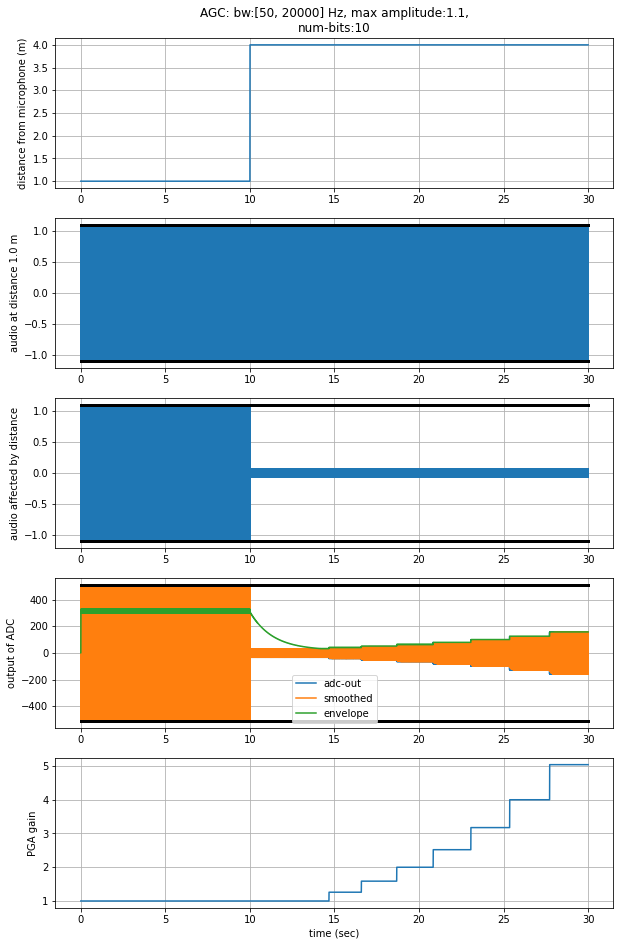

In [1]:
from rockpool.devices.xylo.syns65302.afe.agc.adc import ADC
from rockpool.devices.xylo.syns65302.afe.agc.amplifier import Amplifier
from rockpool.devices.xylo.syns65302.afe.agc.envelope_controller import EnvelopeController
from rockpool.devices.xylo.syns65302.afe.agc.gain_smoother import GainSmootherFPGA
from rockpool.devices.xylo.syns65302.afe.agc.agc_frontend import AGC_ADC

# target audio sampling rate
from rockpool.devices.xylo.syns65302.afe.agc.xylo_a3_agc_specs import AUDIO_SAMPLING_RATE

# analog part parameters
from rockpool.devices.xylo.syns65302.afe.agc.xylo_a3_agc_specs import  XYLO_MAX_AMP, HIGH_PASS_CORNER, LOW_PASS_CORNER

# AGC + gain smoother parameters
from rockpool.devices.xylo.syns65302.afe.agc.xylo_a3_agc_specs import MAX_PGA_GAIN, NUM_BITS_GAIN_QUANTIZATION

from rockpool.timeseries import TSContinuous
import numpy as np

import matplotlib.pyplot as plt


# ================================================
# *       build distance time-series
# ================================================
distance_fs = 4*AUDIO_SAMPLING_RATE
duration = 30
distance_time = np.arange(0, duration, step=1 / distance_fs)

# at ref-distance from microphone the received signal will be rail-to-rail
ref_distance = 1.0

# * Model 2: abrupt movement in front of microphone
distance = ref_distance * np.ones_like(distance_time)
distance[distance_time > duration/3] *= 4

distance_ts = TSContinuous.from_clocked(distance, dt=1 / distance_fs, periodic=True)

# ================================================
# *     build an audio signal
# ================================================
freq = 1000

# original audio signal
audio = XYLO_MAX_AMP * np.sin(2*np.pi*freq*distance_time)

# audio affected by variation of the distance to the microphone
power_attenuation_factor = 4
amplitude_attenuation_factor = power_attenuation_factor/2
audio_modified = audio * (ref_distance / distance**amplitude_attenuation_factor)


# ================================================
# *     build an ADC
# ================================================
num_bits = 10
adc_oversampling_factor = 2     # options: 1, 2, 4 in the current HW design
adc = ADC(
    num_bits=num_bits,
    max_audio_amplitude=XYLO_MAX_AMP,
    oversampling_factor=adc_oversampling_factor,
    fs=AUDIO_SAMPLING_RATE,
)

# =======================================================
# *   build an envelope estimator 
# NOTE: we need to specify two time constants for this depending on how fast we would like the envelope controller
# to respond to signal envelope variations.
#
# We strongly encourage reading the design manual of envelope controller in
# https://spinystellate.office.synsense.ai/saeid.haghighatshoar/agc-for-xylo-v3
#
# `Rule of Thumb`:
# An important parameter is fall_time_constant which specifies if siganl amplitude goes down how fast the reaction time of AGC
# needs to be to adjust/amplify the signal amplitude. 
#
# This typically should be of the order of several seconds so that AGC does not confuse the silent slices of the audio signal
# as attenuated audio.
#
# =======================================================
rise_time_constant = 0.1e-3
fall_time_constant = 1000e-3
num_bits_command = 4

# * set the gain parameters
max_PGA_gain = MAX_PGA_GAIN  # 32 in the current design by the HW team
gain_ratio = max_PGA_gain ** (1 / (2**num_bits_command - 1))

saturation_level = int(min([1 / gain_ratio, 0.6]) * 2 ** (num_bits - 1))

pga_gain_vec = np.asarray([gain_ratio**i for i in range(2**num_bits_command)])

# amplitude thresholds for separating different regions
amplitude_thresholds = (saturation_level / pga_gain_vec[::-1]).astype(np.int64)

# * we designed for a square-root waiting time pattern but for testing we make AGC a little bit faster by decreasing the waiting time slightly
waiting_time_vec = fall_time_constant * np.power(
    np.arange(1, 2**num_bits_command + 1), 1/3
)

max_waiting_time_before_gain_change = np.max(waiting_time_vec)

reliable_max_hysteresis = 5

# * what is the PGA gain index variation specifying the jumps at various regions
# all the other regions are +1 -> increase gain
pga_gain_index_variation = np.ones(2**num_bits_command + 1, dtype=np.int64)

# except for:
pga_gain_index_variation[-1] = -1  # saturation regions
pga_gain_index_variation[-2] = 0  # one level below saturation
pga_gain_index_variation[-3] = 0  # two levels below saturation

# envelope controller
envelope_controller = EnvelopeController(
    num_bits=num_bits,
    amplitude_thresholds=amplitude_thresholds,
    rise_time_constant=rise_time_constant,
    fall_time_constant=fall_time_constant,
    reliable_max_hysteresis=reliable_max_hysteresis,
    waiting_time_vec=waiting_time_vec,
    max_waiting_time_before_gain_change=max_waiting_time_before_gain_change,
    pga_gain_index_variation=pga_gain_index_variation,
    num_bits_command=num_bits_command,
    fs=AUDIO_SAMPLING_RATE,
)


# =======================================================
# *                  build an amplifier
# =======================================================
high_pass_corner = HIGH_PASS_CORNER  # 50 Hz
low_pass_corner = LOW_PASS_CORNER  # 20_000 Hz
fixed_gain_for_PGA_mode = False  # PGA is in AGC mode
amplifier = Amplifier(
    high_pass_corner=high_pass_corner,
    low_pass_corner=low_pass_corner,
    pga_gain_vec=pga_gain_vec,
    settling_time=0.0,
    fixed_gain_for_PGA_mode=fixed_gain_for_PGA_mode,
    fs=distance_fs,
)

# =======================================================
# *          build a gain smoother module
# =======================================================
num_bits_gain_quantization = NUM_BITS_GAIN_QUANTIZATION  # 10 seems to be enough

# minimum waiting time (in seconds) used to set the decay factor of gain smoother
min_waiting_time = envelope_controller.waiting_time_vec.min()

gain_smoother = GainSmootherFPGA(
    num_bits=num_bits,
    min_waiting_time=min_waiting_time,
    num_bits_command=num_bits_command,
    pga_gain_vec=amplifier.pga_gain_vec,
    num_bits_gain_quantization=num_bits_gain_quantization,
    fs=AUDIO_SAMPLING_RATE,
)

# =======================================================
# *       build an ADC with AGC capabilities
# =======================================================
adc_agc = AGC_ADC(
    amplifier=amplifier,
    adc=adc,
    envelope_controller=envelope_controller,
    gain_smoother=gain_smoother,
)


# =======================================================
# *            how to run the simulations
# =======================================================
record = False
progress_report = True

# simulate the system
adc_agc.reset()

# continue
agc_out, state = adc_agc.evolve(
    audio=audio_modified,
    audio_sample_rate=distance_fs,
    record=record,
    progress_report=progress_report,
)

# ===========================================================================
#                         Plot and save the results
# ===========================================================================
plt.figure(figsize=(10, 16))

plt.subplot(511)
plt.plot(distance_time, distance)
plt.ylabel("distance from microphone (m)")
plt.grid(True)
plt.title(
    f"AGC: bw:{[int(amplifier.high_pass_corner), int(amplifier.low_pass_corner)]} Hz, max amplitude:{adc.max_audio_amplitude},\nnum-bits:{adc.num_bits}"
)

plt.subplot(512)
audio_norm = XYLO_MAX_AMP * audio / np.max(np.abs(audio))
plt.plot(np.linspace(0, duration, len(audio_norm)), audio_norm)
plt.plot([0, duration], [XYLO_MAX_AMP, XYLO_MAX_AMP], "k", linewidth=3)
plt.plot([0, duration], [-XYLO_MAX_AMP, -XYLO_MAX_AMP], "k", linewidth=3)
plt.grid(True)
plt.ylabel(f"audio at distance {ref_distance} m")

plt.subplot(513)
plt.plot(np.linspace(0, duration, len(audio_modified)), audio_modified)
plt.plot([0, duration], [XYLO_MAX_AMP, XYLO_MAX_AMP], "k", linewidth=3)
plt.plot([0, duration], [-XYLO_MAX_AMP, -XYLO_MAX_AMP], "k", linewidth=3)
plt.grid(True)
plt.ylabel("audio affected by distance")

plt.subplot(514)
max_adc_val = 2 ** (adc.num_bits - 1) - 1
min_adc_val = -max_adc_val

plt.plot(np.linspace(0, duration, len(state["adc_output"])), state["adc_output"], label="adc-out")
plt.plot(
    np.linspace(0, duration, len(state["gain_smoother_output"])),
    state["gain_smoother_output"],
    label="smoothed",
)
plt.plot(
    np.linspace(0, duration, len(state["envelope"])),
    state["envelope"],
    label="envelope",
)
plt.plot([0, duration], [max_adc_val, max_adc_val], "k", linewidth=3)
plt.plot([0, duration], [min_adc_val, min_adc_val], "k", linewidth=3)
plt.legend()
plt.grid(True)
plt.ylabel("output of ADC")

plt.subplot(515)
plt.plot(
    np.linspace(0, duration, len(state["agc_pga_gain"])), state["agc_pga_gain"]
)
plt.grid(True)
plt.ylabel("PGA gain")

plt.xlabel("time (sec)")
plt.draw()

plt.show()


--- 

## Effect of Gain Smoother
By focusing at the plots at PGA gain transition times, we can see that the output of internal ADC undergoes jumps due to jumps in the gain of PGA at those points.
However, gain smoother corrects these jumps and allows a smooth transition of signal at those points.

This is more important at high signal amplitues and avoids introducing nonlinear distortion due to signal jumps.

In our design we make sure that the gain smoothing reaches its steady-state before the next gain change happens in PGA. 
The parameter that controls this is  `min_waiting_time`: the time constant of the gain smoothing filter is set to `min_waiting_time / 5`.



(-150.0, 150.0)

WARNING    /Users/ugurcancakal/rockpool/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
 [py.warnings]
  fig.canvas.print_figure(bytes_io, **kw)



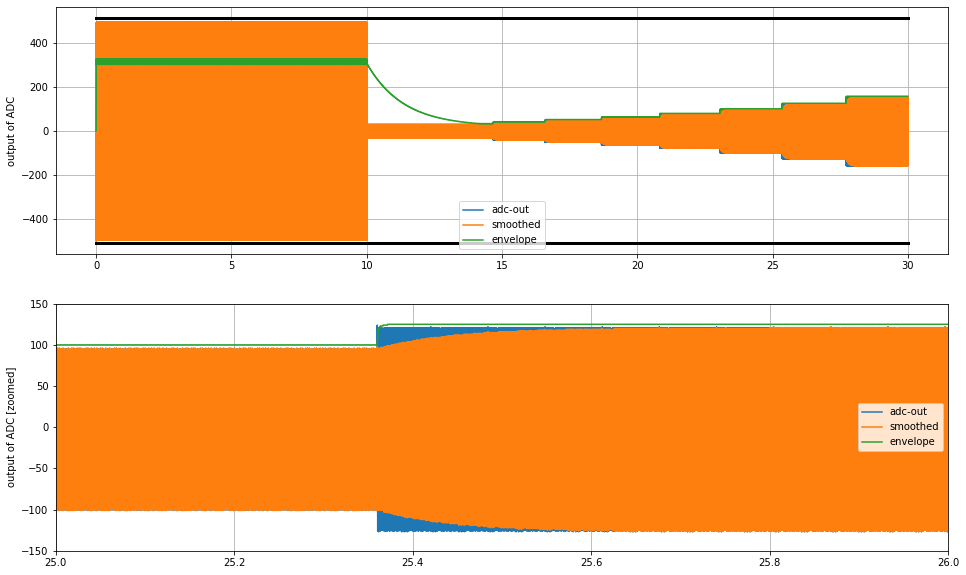

In [2]:
max_adc_val = 2 ** (adc.num_bits - 1) - 1
min_adc_val = -max_adc_val

plt.figure(figsize=(16,10))

plt.subplot(211)
plt.plot(np.linspace(0, duration, len(state["adc_output"])), state["adc_output"], label="adc-out")
plt.plot(
    np.linspace(0, duration, len(state["gain_smoother_output"])),
    state["gain_smoother_output"],
    label="smoothed",
)
plt.plot(
    np.linspace(0, duration, len(state["envelope"])),
    state["envelope"],
    label="envelope",
)
plt.plot([0, duration], [max_adc_val, max_adc_val], "k", linewidth=3)
plt.plot([0, duration], [min_adc_val, min_adc_val], "k", linewidth=3)
plt.legend()
plt.grid(True)
plt.ylabel("output of ADC")


plt.subplot(212)
plt.plot(np.linspace(0, duration, len(state["adc_output"])), state["adc_output"], label="adc-out")
plt.plot(
    np.linspace(0, duration, len(state["gain_smoother_output"])),
    state["gain_smoother_output"],
    label="smoothed",
)
plt.plot(
    np.linspace(0, duration, len(state["envelope"])),
    state["envelope"],
    label="envelope",
)
plt.plot([0, duration], [max_adc_val, max_adc_val], "k", linewidth=3)
plt.plot([0, duration], [min_adc_val, min_adc_val], "k", linewidth=3)
plt.legend()
plt.grid(True)
plt.ylabel("output of ADC [zoomed]")

plt.xlim([25, 26])
plt.ylim([-150, 150])






# Summary
In this tutorial, we provided an overview of deisgnfor AGC module in Xylo-A3. 
We also provided a numerical simulation of modules for a practical prroblem where the audio amplitude undergoes sudden attenuation and AGC is used to compensate it.